# Interpretability

In [2]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2

https://christophm.github.io/interpretable-ml-book/

## Global Model-Agnostic Methods

### Permutation Feature Importance

Measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome.

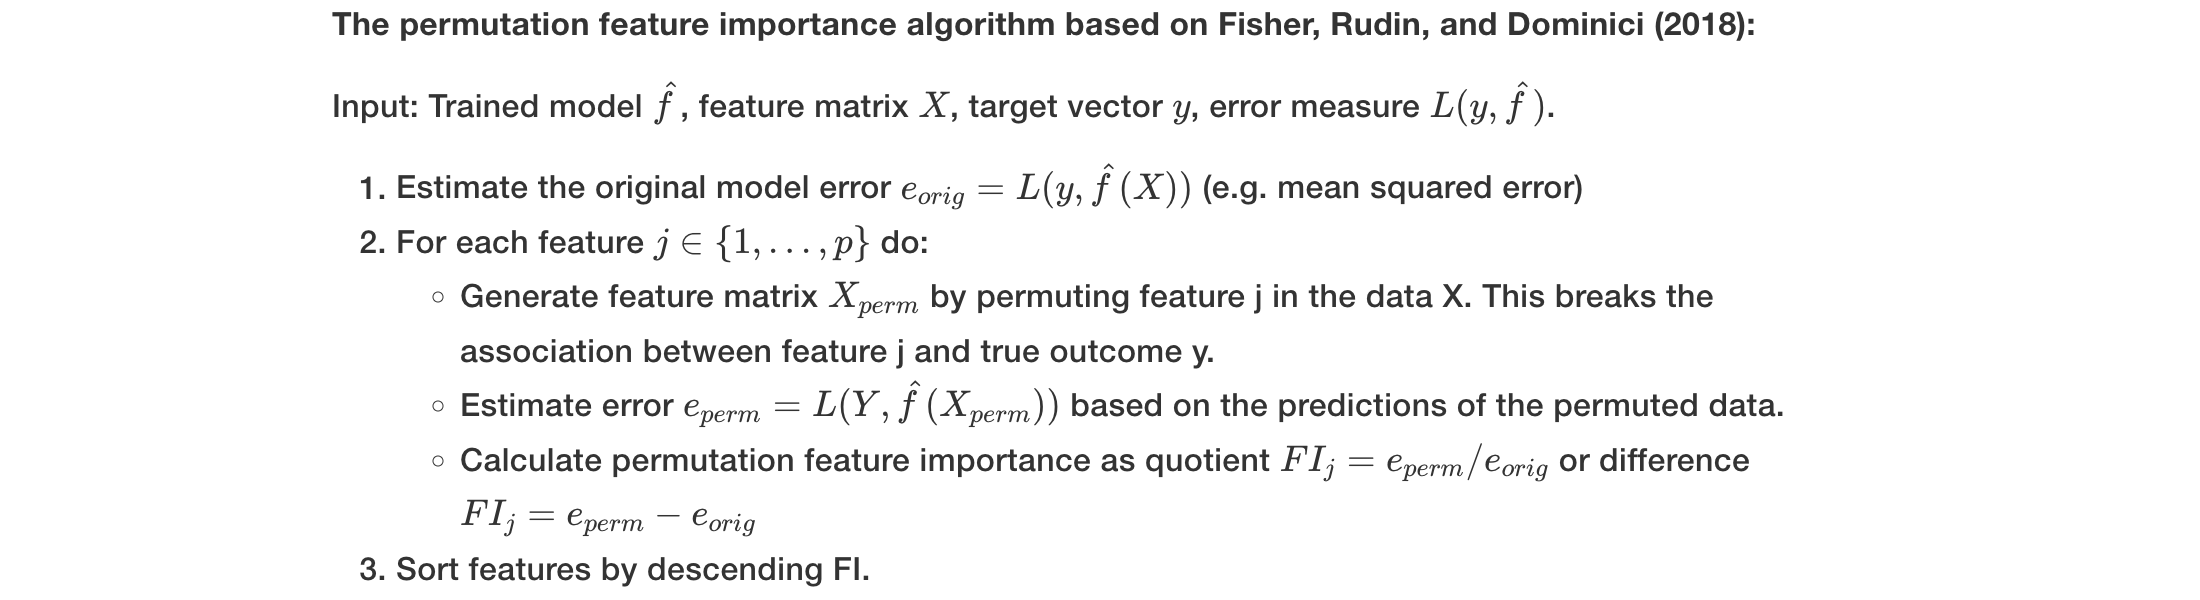

In [77]:
import argparse
import yaml
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import mlflow
from src.models.LSTM.data import load_data
from src.misc import split_data, evaluate, plot, create_sequences
from sklearn.preprocessing import StandardScaler
import pandas as pd

def rmse(targets, predictions):
    """Calculate the RMSE between targets and predictions."""
    return torch.sqrt(torch.mean((targets - predictions) ** 2))


def measure_performance(model, data_loader, criterion):
    model.eval()
    total_metric = 0
    for X, y in data_loader:
        with torch.no_grad():
            outputs = model(X)
            metric_value = criterion(outputs, y)
            total_metric += metric_value.item()
    return total_metric / len(data_loader)

def calculate_permutation_importance(model, data_loader, n_features, criterion):
    baseline_performance = measure_performance(model, data_loader, criterion)
    print(f'Baseline performance: {baseline_performance}')
    importance_scores = []

    # Convert DataLoader back to dataset for permutation (assumes batch size of 1 for simplicity)
    original_data = next(iter(data_loader))[0].numpy()  # Shape: (n_samples, window_size, n_features)
    for feature_index in range(n_features):
        # Permute feature values across all samples and windows
        permuted_data = original_data.copy()
        reshaped_data = permuted_data.reshape(-1, n_features)  # Flatten samples and windows
        np.random.shuffle(reshaped_data[:, feature_index])  # Permute only the current feature
        permuted_data = reshaped_data.reshape(original_data.shape)  # Reshape back to original 3D structure
        
        # Create a new DataLoader for the permuted dataset
        permuted_tensor = torch.tensor(permuted_data, dtype=torch.float32)
        permuted_loader = DataLoader(TensorDataset(permuted_tensor, y_test_tensor), batch_size=1)
        
        # Evaluate model performance on permuted data
        permuted_performance = measure_performance(model, permuted_loader, criterion)
        print(f'Feature {feature_index} permuted performance: {permuted_performance}')
        
        # Calculate and record the importance score
        importance = permuted_performance/baseline_performance  # Adjust calculation as needed
        importance_scores.append(importance)

    return importance_scores

In [78]:
# Load the configuration file:
with open("/Users/simon/Documents/II/Dissertation/configs/lstm.yaml", "r") as file:
    config = yaml.safe_load(file)
features = config["data"]["features"]
sequence_len = config["data"]["sequence_len"]


In [83]:
# Prepare  dataset
X, y = load_data(features=features)
print(X.shape, y.squeeze().shape)

# Sequencing
X_seq, y_seq = create_sequences(X, y.squeeze(), sequence_len)
print(X_seq.shape, y_seq.reshape(-1,1,1).shape)

# Split
X_train, _, X_test = split_data(X_seq, verbose=False)
y_train, _, y_test = split_data(y_seq.reshape(-1,1,1), verbose=False)
print(X_train.shape, y_train.shape)

# Normalisation
# Reshape to 2D: [n_samples * n_time_steps, n_features]
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
print(X_train_reshaped.shape, y_train_reshaped.shape)

in_scaler = StandardScaler()
out_scaler = StandardScaler()
X_train_norm = in_scaler.fit_transform(X_train_reshaped)
X_test_norm  = in_scaler.transform(X_test_reshaped)
y_train_norm = out_scaler.fit_transform(y_train_reshaped)
y_test_norm  = out_scaler.transform(y_test_reshaped)

# Reshape back to 3D
X_test_norm_3d = X_test_norm.reshape(X_test.shape)
y_test_norm_3d = y_test_norm.reshape(y_test.shape)

# TensorDatasets and DataLoaders
X_test_tensor = torch.tensor(X_test_norm_3d.astype(np.float32))
y_test_tensor = torch.tensor(y_test_norm_3d.astype(np.float32))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

(1259, 5) (1259,)
(1200, 60, 5) (1200, 1, 1)
(960, 60, 5) (960, 1, 1)
(57600, 5) (960, 1)


/Users/simon/Documents/II/Dissertation/src/misc.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(ys[i-1])


In [3]:
from src.misc import load_pytorch_model_from_latest_run
model =load_pytorch_model_from_latest_run("lstm")
calculate_permutation_importance(model, test_loader, 5, rmse)

NameError: name 'calculate_permutation_importance' is not defined

## Local Model-Agnostic Methods